# 4 - Monte Carlo Integration (II)

##### Imports:

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import scipy.stats as stats 
import time

The following package is installed to easily create dataframes.

In [2]:
import pandas as pd

##### Configure matplotlib settings

In [3]:
plt.style.use('ggplot')
plt.rcParams.update(
    {"text.usetex": True,
     "font.serif": "Modern Roman",
     "figure.figsize": (10, 8),
     "axes.titlesize" : 26,
     "axes.labelsize" : 28,
     "lines.linewidth": 3,
     "lines.markersize" : 10,
     "legend.fontsize":20,
     "xtick.labelsize" : 24,
     "ytick.labelsize" : 24})

In [4]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

##### Functions:

In [5]:
def radius(x): 
    '''Calculates the distance from origin to a vector'''
    return np.sqrt(np.dot(x, x))

In [6]:
def flip_coin(p):
    '''Return True with probability p, return false with probability 1-p'''
    x = random.uniform(0, 1)
    if x <= p:
        return True
    else:
        return False

In [7]:
def update_pos(pos, h):
    '''Updates the position according to metropolis algorithm described in the exercise.'''
    
    # Propose a step in the random walk
    delta = np.array([random.uniform(-h/2, h/2), random.uniform(-h/2, h/2), random.uniform(- h/2, h/2)])
    newpos = pos + delta
    
    # Accept if closer to origin OR according to acceptance ratio
    if  (radius(newpos))**2 < (radius(pos))**2:
        return newpos
    else:
        A = np.exp(-0.5*((radius(newpos))**2 - (radius(pos))**2))  # acceptance ratio
        if flip_coin(A) == True:
            return newpos
        else:
            return pos

In [8]:
def get_random_walk(nstep, h, start_pos = np.array([0, 0, 0])):
    '''Performs a random walk of specified length according to the Metropolis algorithm.'''
    # Save initial position as first step
    walk = [start_pos]
    
    # Perform the walk
    for step in range(nstep):
        newpos = update_pos(walk[-1], h)
        walk.append(newpos)
    
    return walk

In [9]:
def gaussian(t, mu = 0, sigma = 1):
    '''Plots a Gaussian with mean mu and standard deviation sigma. Taken from Exercise 2.'''
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-((t-mu)/sigma)**2/2)

In [10]:
def approximate_integral(npts, nrep, h, start_pos = np.array([0, 0, 0])):
    '''Numerical approximation of the integral using Metropolis algorithm. (See exercise 4.2)'''
    I = []
    pos = start_pos
    
    for k in range(nrep):
        s = 0
        
        for i in range(npts):
            
            if i == 0:
                x, y, z = pos[0],  pos[1], pos[2]
                s += (x+y+z)**2 # = g(x, y, z)

            else:
                newpos = update_pos(pos, h)
                x, y, z = newpos[0], newpos[1], newpos[2]
                s += (x+y+z)**2 # = g(x, y, z)
                
                pos = newpos
        
        # Return the average, multiplied with a prefactor (see report for details)
        I.append(s*(2*np.pi)**(1.5)/npts)
    return I

In [11]:
def compute_new_average(averages, value):
    N = len(averages)
    
    if N == 0:
        return value
    
    else:
        return (N/(N+1))*averages[-1] + value/(N+1)

In [12]:
def steps_integral(npts, h, start_pos = np.array([0, 0, 0]), equilibriate = False, prev_averages = []):
    '''Saves all the intermediate steps when calculating the approximation for the integral. (See exercise 4.4)'''
    
    # Define initial position: start from given initial point, or let a random walk equilibriate first
    if prev_averages == []:
        averages = []
    else:
        averages = prev_averages
    
    if equilibriate == False:
        pos = start_pos
    
    elif equilibriate == True:
        nstep = 100 # determine how many steps need to be done before equilibriation is reached
        walk = get_random_walk(nstep, h, start_pos)
        pos = walk[-1]
    
    for i in range(npts):        

        newpos = update_pos(pos, h)
        x, y, z = newpos[0], newpos[1], newpos[2]
        
        # Compute new value and new average
        value= (x+y+z)**2 # = g(x, y, z)
        new_average = compute_new_average(averages, value)
        averages.append(new_average)
            
        pos = newpos
    
    return averages, pos

Store the exact value of the integral, and define the function $g$ used in the functions above to approximate the integral (see also Problem 3):

In [13]:
exact = 3*(2*np.pi)**1.5

In [14]:
def g(x, y, z):
    return (x + y + z)**2

## 4.1 - Trajectories


In [15]:
nstep = 10**4

### 4.1.1 - Trajectory from $\mathbf{r}_0 = (0, 0, 0)$

Starting position: origin. Note that the function $\texttt{get_random_walk}$ takes the origin by default as starting position. 

In the next command block, I change the width of the lines with which matplotlib plots, since otherwise the figure is a mess.

In [16]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.linestyle'] = '--'
plt.rcParams['lines.markersize'] = 3

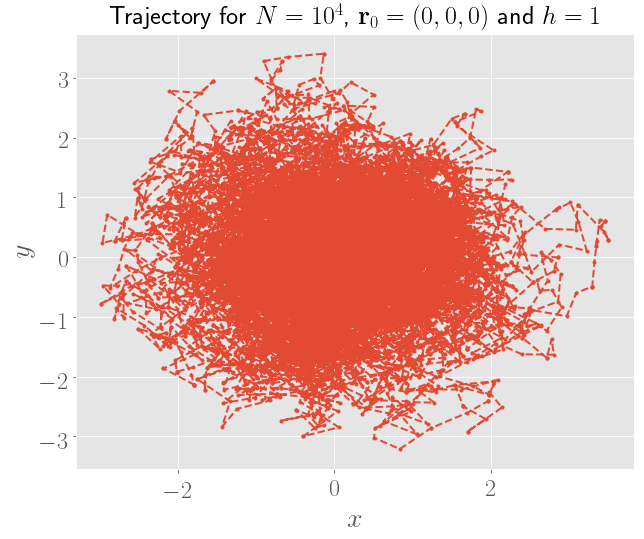

In [17]:
h = 1
walk = get_random_walk(nstep, h)
x = [v[0] for v in walk]; y = [v[1] for v in walk]

plt.plot(x, y, marker = 'o')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory for $N = 10^4$, $\mathbf{r}_0 = (0, 0, 0)$ and $h = 1$')
plt.savefig('ex4_origin_h1.pdf', bbox_inches = 'tight')
plt.show()

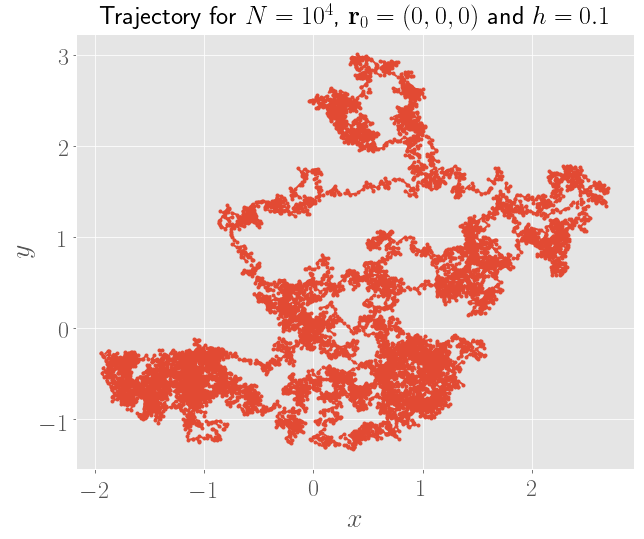

In [18]:
h = 0.1
walk = get_random_walk(nstep, h)
x = [pos[0] for pos in walk]; y = [pos[1] for pos in walk]

plt.plot(x, y, marker = 'o')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory for $N = 10^4$, $\mathbf{r}_0 = (0, 0, 0)$ and $h = 0.1$')
plt.savefig('ex4_origin_h01.pdf', bbox_inches = 'tight')
plt.show()

## 4.1.2 - Trajectory from $\mathbf{r}_0 = (10, 10, 10)$

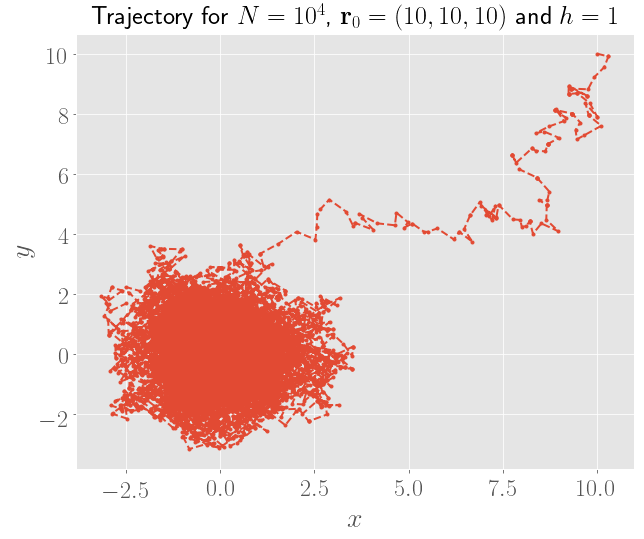

In [19]:
h = 1; start_pos = np.array([10, 10, 10])
walk = get_random_walk(nstep, h, start_pos)
x = [pos[0] for pos in walk]; y = [pos[1] for pos in walk]

plt.plot(x, y, marker = 'o')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory for $N = 10^4$, $\mathbf{r}_0 = (10, 10, 10)$ and $h = 1$')
plt.savefig('ex4_away_h1.pdf', bbox_inches = 'tight')
plt.show()

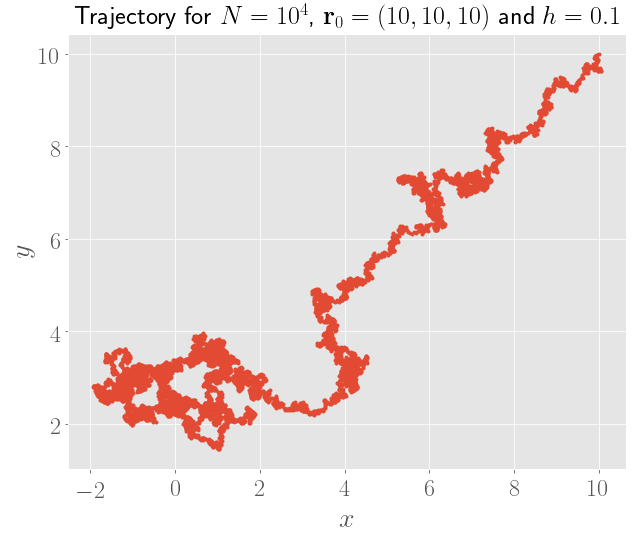

In [20]:
h = 0.1;  start_pos = np.array([10, 10, 10])
walk = get_random_walk(nstep, h, start_pos)
x = [pos[0] for pos in walk]; y = [pos[1] for pos in walk]

plt.plot(x, y, marker = 'o')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory for $N = 10^4$, $\mathbf{r}_0 = (10, 10, 10)$ and $h = 0.1$')
plt.savefig('ex4_away_h01.pdf', bbox_inches = 'tight')
plt.show()

### 4.2.1 - Histogram of positions: for $\mathbf{r}_0 = (0, 0, 0)$

Change the matplotlib configurations again.

In [21]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams['lines.markersize'] = 3

In [22]:
# Get a random walk for nstep = 10^6
nstep = 10**6; h = 1
walk = get_random_walk(nstep, h)

In [23]:
# Obtain magnitudes of positions - after some time (let it equilibriate)
distances = [radius(pos) for pos in walk[1000:]]
x = [pos[0] for pos in walk[1000:]]; y = [pos[1] for pos in walk[1000:]]

In [24]:
# plt.hist2d(x, y, normed= True, bins = 40)
# plt.colorbar()
# plt.show()

$\textbf{Histogram of distances: TODO: seems to be    } r \exp(-r^2/2)$

In [25]:
def radial_distr(x, a):
    return (x-a)*np.exp(-(x-a)**2/2)

In [26]:
np.mean(distances)

1.59952469185231

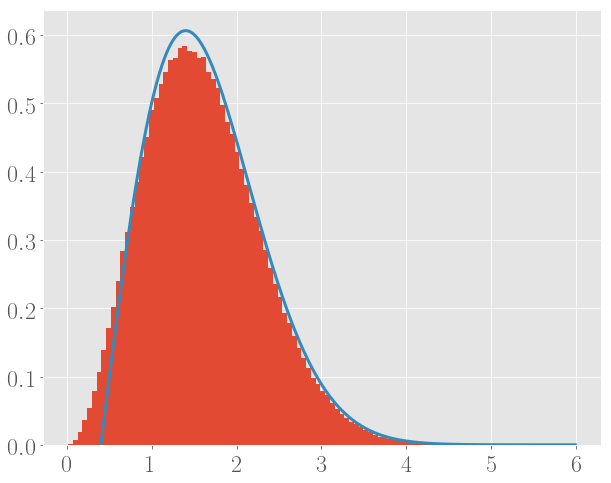

In [27]:
plt.hist(distances, density = True, bins = 100)
t = np.arange(0.4, 6, 0.01)
y = radial_distr(t, 0.4)
plt.plot(t, y)
plt.show()

We can also look at marginal distributions for each coordinate: this is done below (now commented). The result are all nice Gaussian distributions.

In [28]:
## Save for each coordinate after a certain time: let it equilibrate for some time
#xdata = [v[0] for v in walk]; ydata = [v[1] for v in walk]; zdata = [v[2] for v in walk]

In [29]:
# plt.hist(xdata, density = True, bins = 100, alpha = 0.7)
# t = np.arange(-4, 4, 0.1)
# y = gaussian(t)
# plt.plot(t, y, label = 'Standard Gaussian curve')
# plt.show()

In [30]:
# plt.hist(ydata, density = True, bins = 100, alpha = 0.7)
# t = np.arange(-4, 4, 0.1)
# y = gaussian(t)
# plt.plot(t, y, label = 'Standard Gaussian curve')
# plt.show()

In [31]:
# plt.hist(zdata, density = True, bins = 100, alpha = 0.7)
# t = np.arange(-4, 4, 0.1)
# y = gaussian(t)
# plt.plot(t, y, label = 'Standard Gaussian curve')
# plt.show()

## 4.2 - Numerical integration

In [36]:
#Number of points per run: npts; Number of replicas: nrep
npts = 10**4; nrep = 100;

The following code block can take some time. Play around with npts and nrep.

In [37]:
I = approximate_integral(npts, nrep, h = 1)

In [38]:
print('Approximation was %0.4f, exact value is %0.4f and sample standard deviation was %0.4f' % (np.mean(I), exact, np.std(I)))

Approximation was 47.6107, exact value is 47.2488 and sample standard deviation was 3.8793


## 4.3 - Equilibration 

Starting from $\mathbf{r}_0 = (10, 10, 10)$, we determine how long it takes for equilibration for $h = 1$ and $h = 0.1$.

Initially, the distance is:

In [39]:
np.sqrt(300)

17.320508075688775

Take $h = 1$:

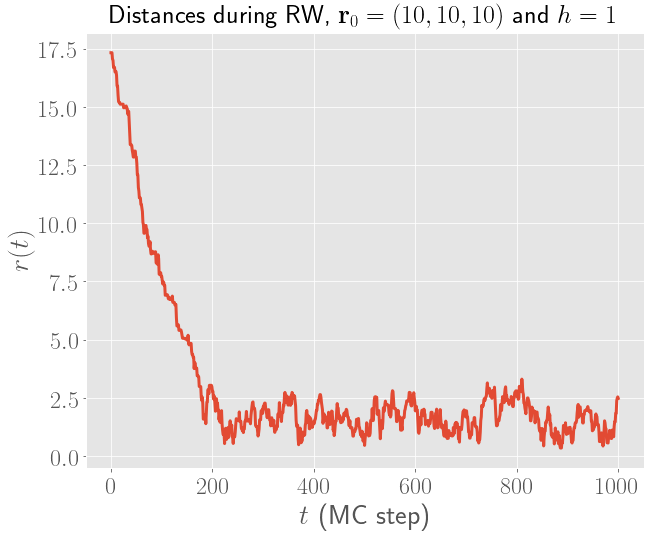

In [40]:
# Configurate & do the random walk
start_pos = np.array([10, 10, 10]); h = 1; nstep = 10**3
walk = get_random_walk(nstep, h, start_pos)

# Obtain the distances
r = [radius(x) for x in walk]

plt.plot(r)
plt.xlabel(r'$t$ (MC step)')
plt.ylabel(r'$r(t)$')
plt.title(r'Distances during RW, $\mathbf{r}_0 = (10, 10, 10)$ and $h = 1$')
#plt.savefig('ex4_equilibration_1.pdf', bbox_inches = 'tight')
plt.show()

Take $h = 0.1$:

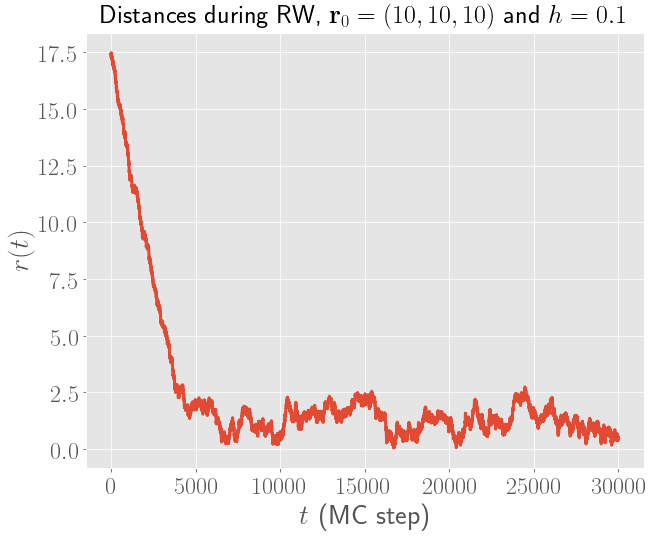

In [41]:
# Configurate & do the random walk
start_pos = np.array([10, 10, 10]); h = 0.1; nstep = 3*10**4
walk = get_random_walk(nstep, h, start_pos)

# Obtain the distances
r = [radius(x) for x in walk]

plt.plot(r)
plt.xlabel(r'$t$ (MC step)')
plt.ylabel(r'$r(t)$')
plt.title(r'Distances during RW, $\mathbf{r}_0 = (10, 10, 10)$ and $h = 0.1$')
#plt.savefig('ex4_equilibration_01.pdf', bbox_inches = 'tight')
plt.show()

### 4.4 - Comparison with the Gaussian method from problem 3

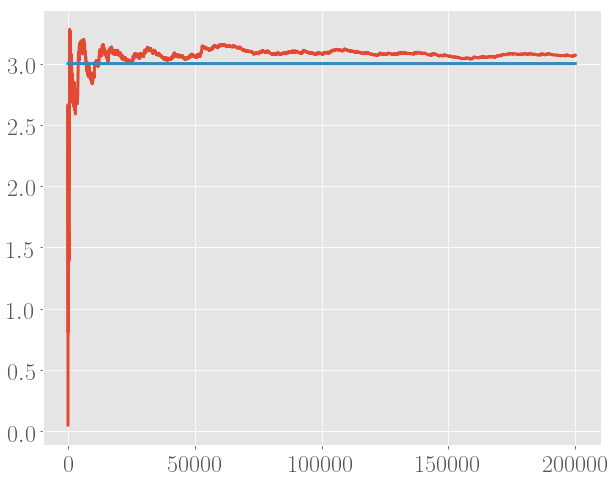

In [64]:
npts = 2*10**5; h = 1
avgs, final1 = steps_integral(npts, h) # avgs as abbreviation for averages; use another name than in function


## Check graphically if this was a good approximation or not.
plt.plot(avgs)
plt.plot([3 for i in range(len(avgs))])

plt.show()

The output from above is quite inconsistent, which is a first indication that Metropolis is not always reliable as an approximation. I saved a good run of the above code cell using pickle. It can be loaded again afterwards using pickle. A good run is saved in the file good_avgs.

In [56]:
import pickle

In [58]:
# ## Save the averages
# with open('good_avgs', 'wb') as f:
#     pickle.dump(avgs, f)

The run can be loaded again afterwards using pickle.

In [59]:
with open('avgs_origin', 'rb') as f:
    good_avgs = pickle.load(f)

###### Important note to self!!! Don't forget to give starting point and value of $h$ in caption of the figure in the report.

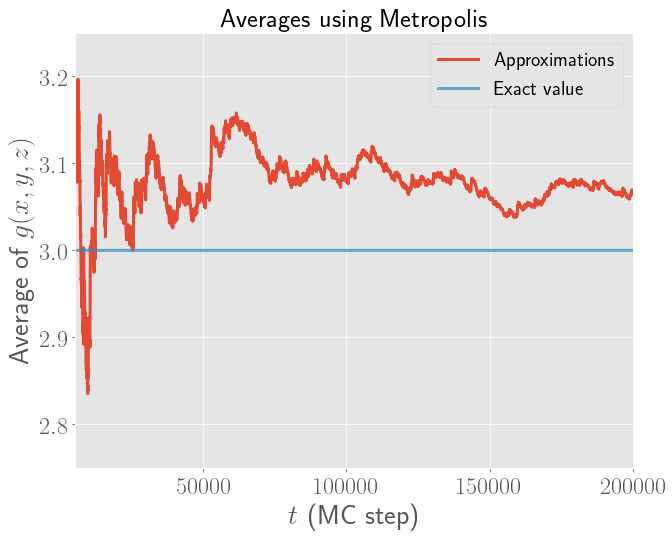

In [65]:
### Decide what to plot: 
##    - avgs is output generated by running code above;
##   -  good_avgs is saved data from one of the better Metropolis runs.

# x = good_avgs
x = avgs

# Plot
plt.plot(x, label = 'Approximations')
plt.plot([3 for i in range(len(x))], alpha = 0.75, label = 'Exact value')

# Make fancy, save and show
plt.ylim(2.75, 3.25)
plt.xlim(5000, len(x))
plt.legend()
plt.xlabel(r'$t$ (MC step)')
plt.ylabel(r'Average of $g(x, y, z)$')
plt.title(r'Averages using Metropolis')

#plt.savefig('ex4_comparison_Metropolis.pdf', bbox_inches = 'tight')
plt.show()

## BONUS: Random Walk animation

This is unfinished.

In [ ]:
# def run(i):
#     global walk
#     # first frame
#     if i == 0:
#         line, = ax.plot([], [], lw=2)
#         #ax.plot(0, 0)
#         return line

#     # update:
#     newpos = update_pos(walk[-1], h)
#     walk.append(newpos)
    
#     # data
#     xdata = [pos[0] for pos in walk]
#     ydata = [pos[1] for pos in walk]
    
#     # new bounds:
#     ax.set_xlim(min(-1, min(xdata) - 1), max(1, max(xdata) + 1))
#     ax.set_ylim(min(-1, min(ydata) - 1), max(1, max(ydata) + 1))
    
#     # redraw the plot
#     line, = ax.plot([], [], lw=2)
#     line.set_data(xdata, ydata)
#     ax.plot(walk[-1][0], walk[-1][1])
  
#     return line

In [ ]:
# # Create an animation for a random walk
# walk = [np.array([0, 0, 0])] # starting point

# fig, ax = plt.subplots()
# ax.set_xlim(-1,1)
# ax.set_ylim(-1,1)
# anim = animation.FuncAnimation(fig, run, frames = 400, interval=20)

Uncomment the next code block to get the animation. Note: takes some time!

In [31]:
# HTML(anim.to_jshtml()) # uncomment this to generate the animation Warning: takes a bit of time - play around with 'frames' to change this